In [1]:
%cd ..


c:\Repositories\omrtorch


In [2]:
from omrengine import OMREngine
import glob
import os
import cv2 as cv
import numpy as np
from PIL import Image
from importlib import reload
import music21

from omrmodules.semantics.SystemObjects import SongFactory
from omrmodules.datasets.MuscimaMeasures import visualize_bboxes


In [3]:
omrengine = OMREngine()


In [4]:
IMAGE = os.path.join("samples", "demo_score.png")
sample_image = cv.imread(IMAGE)
sample_image = OMREngine.preprocess(sample_image)


In [5]:
sample_image.shape


(1, 1409, 1948)

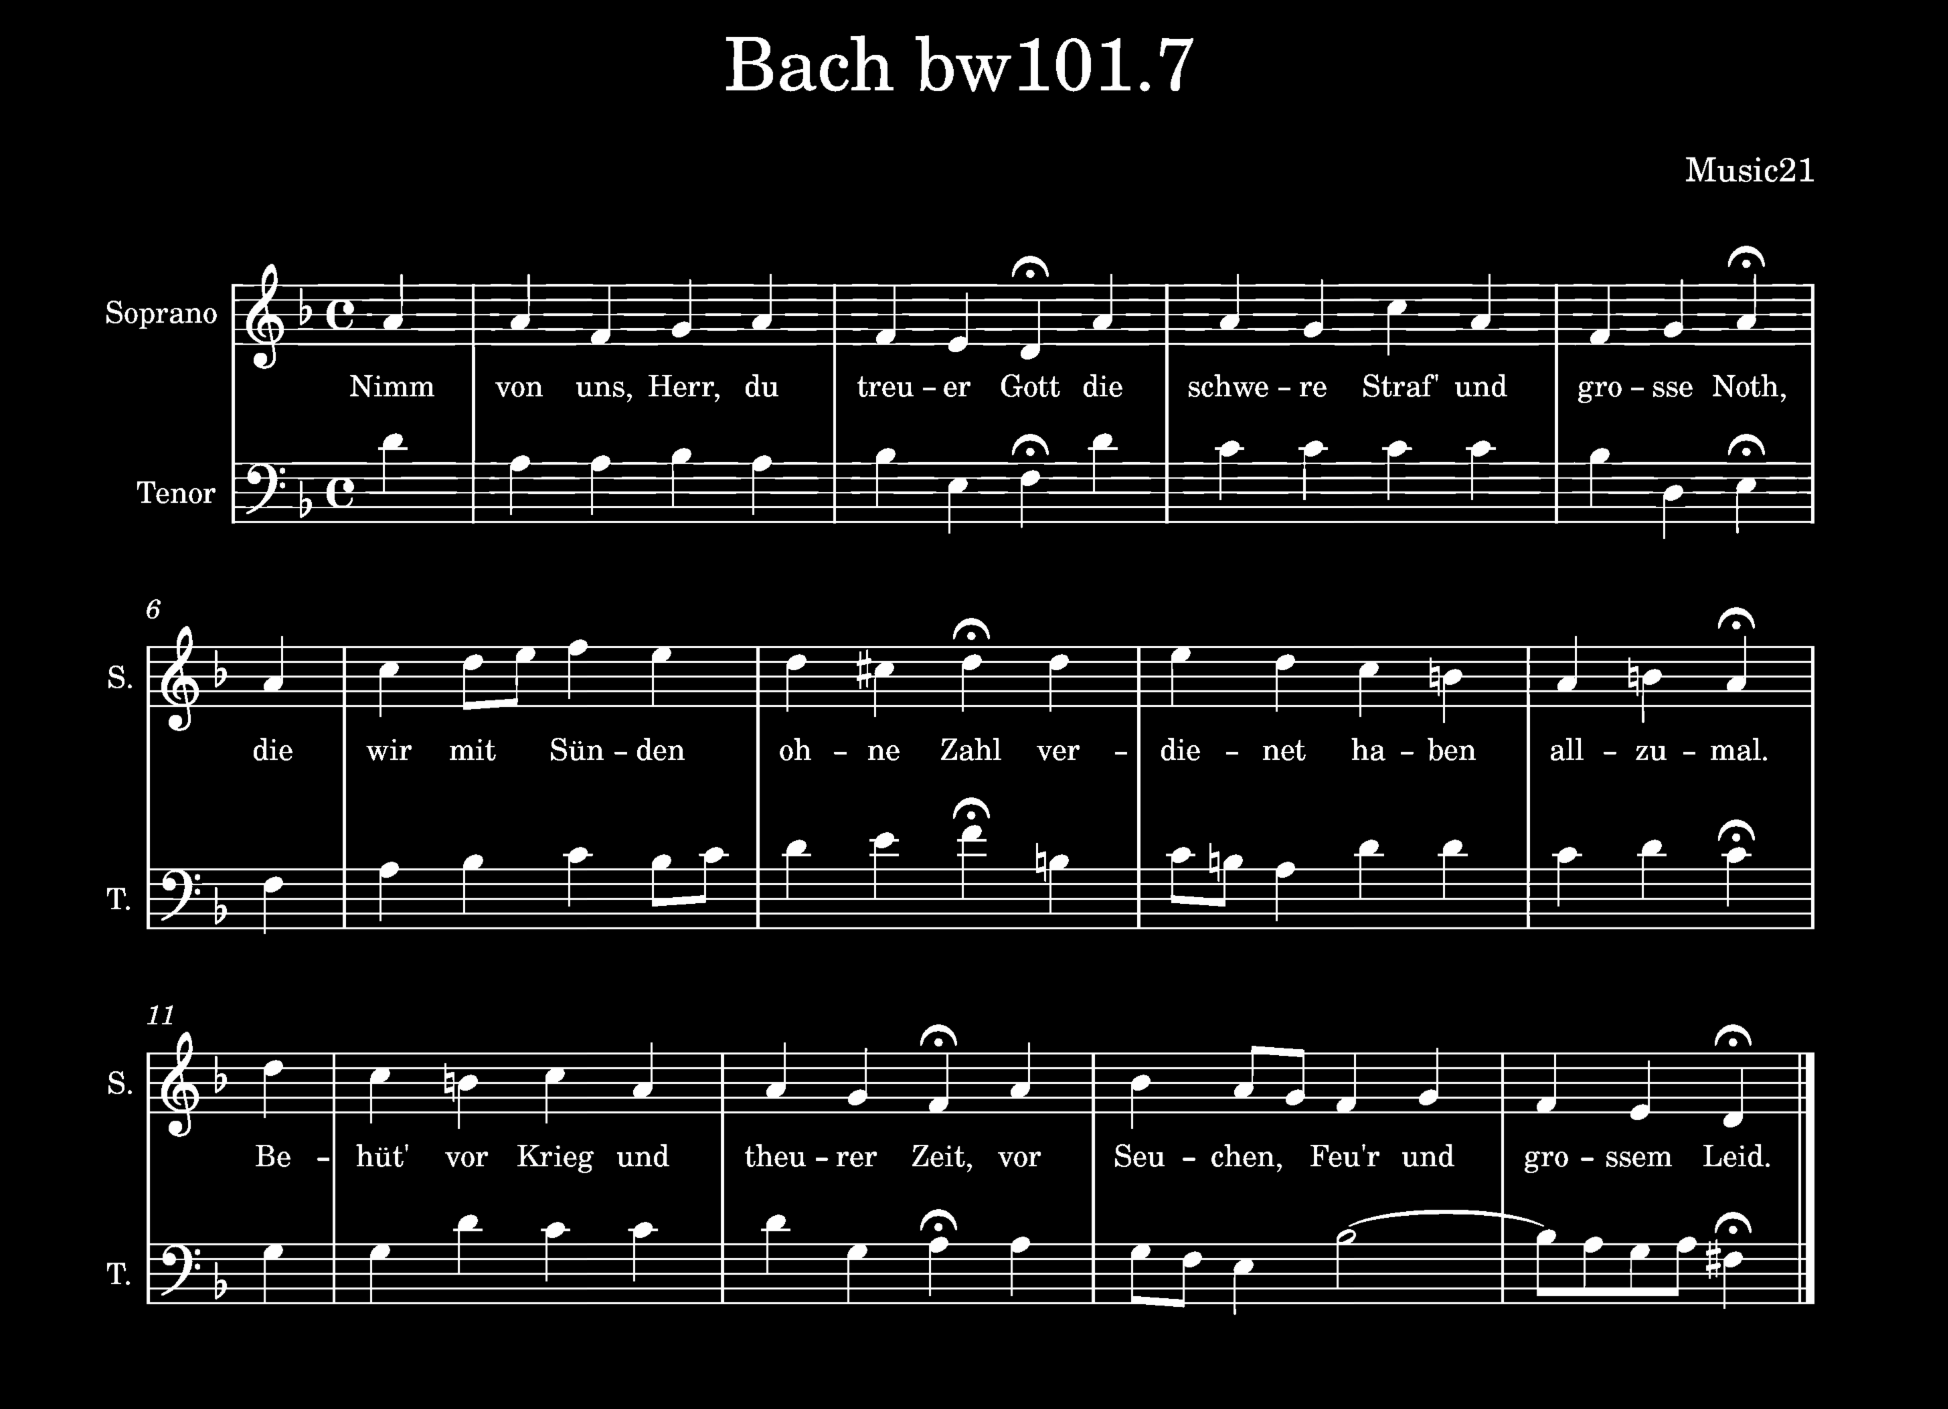

In [6]:
def ppoToImage(x): return (
    np.repeat(np.moveaxis(x, 0, 2), 3, 2) * 255).astype(np.uint8)


def ShowPreProcessedImage(x): return Image.fromarray(ppoToImage(x))


ShowPreProcessedImage(sample_image)


In [7]:
measure_dict, object_dict = omrengine(sample_image)


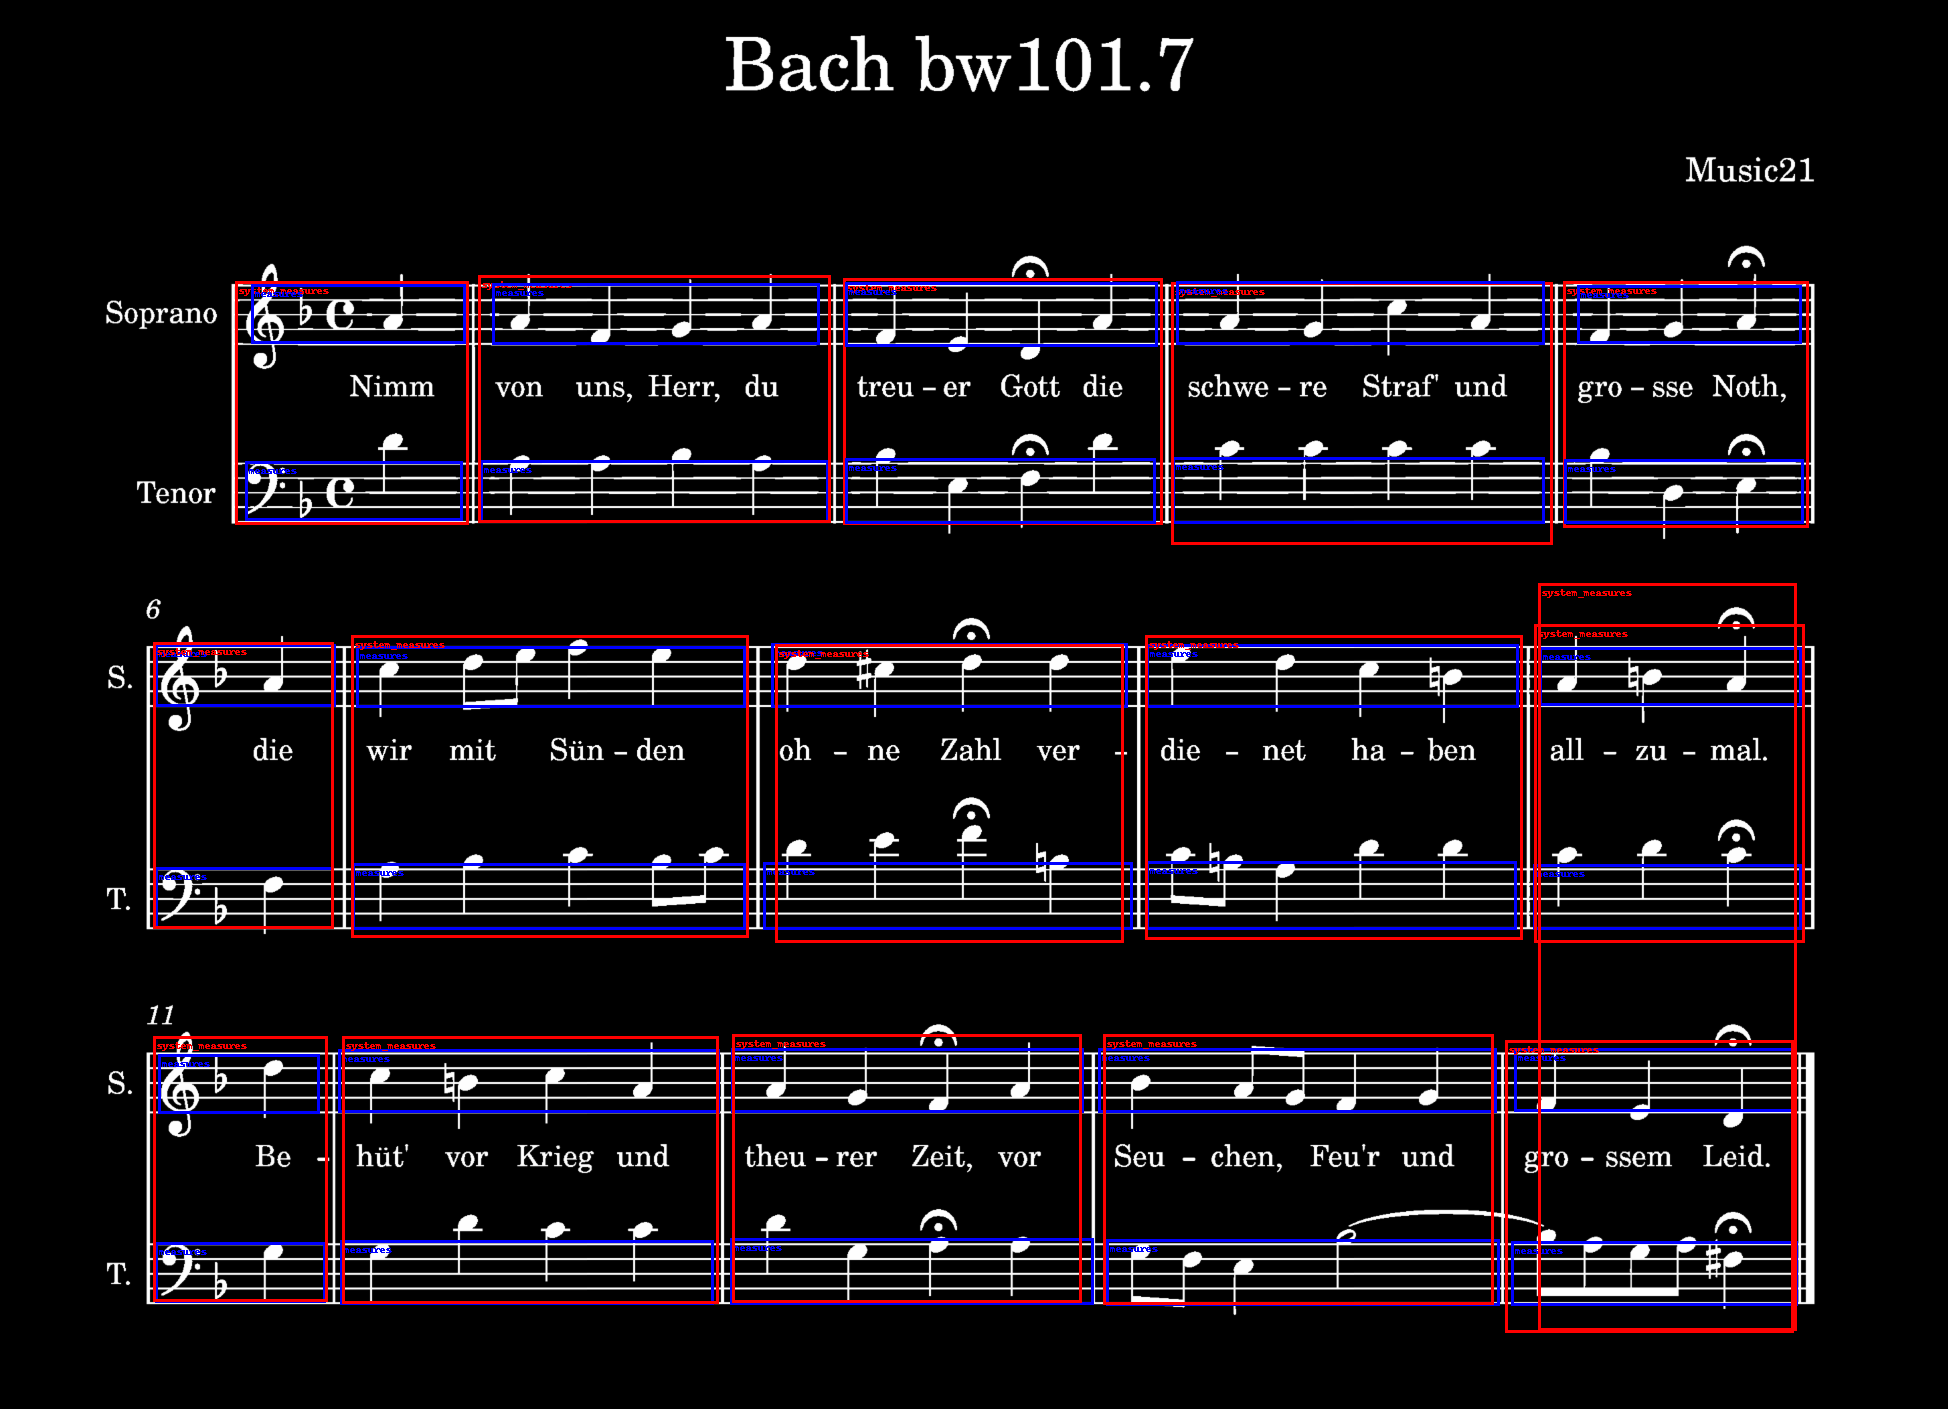

In [8]:
visualize_bboxes(sample_image, measure_dict, threshold=0.75)


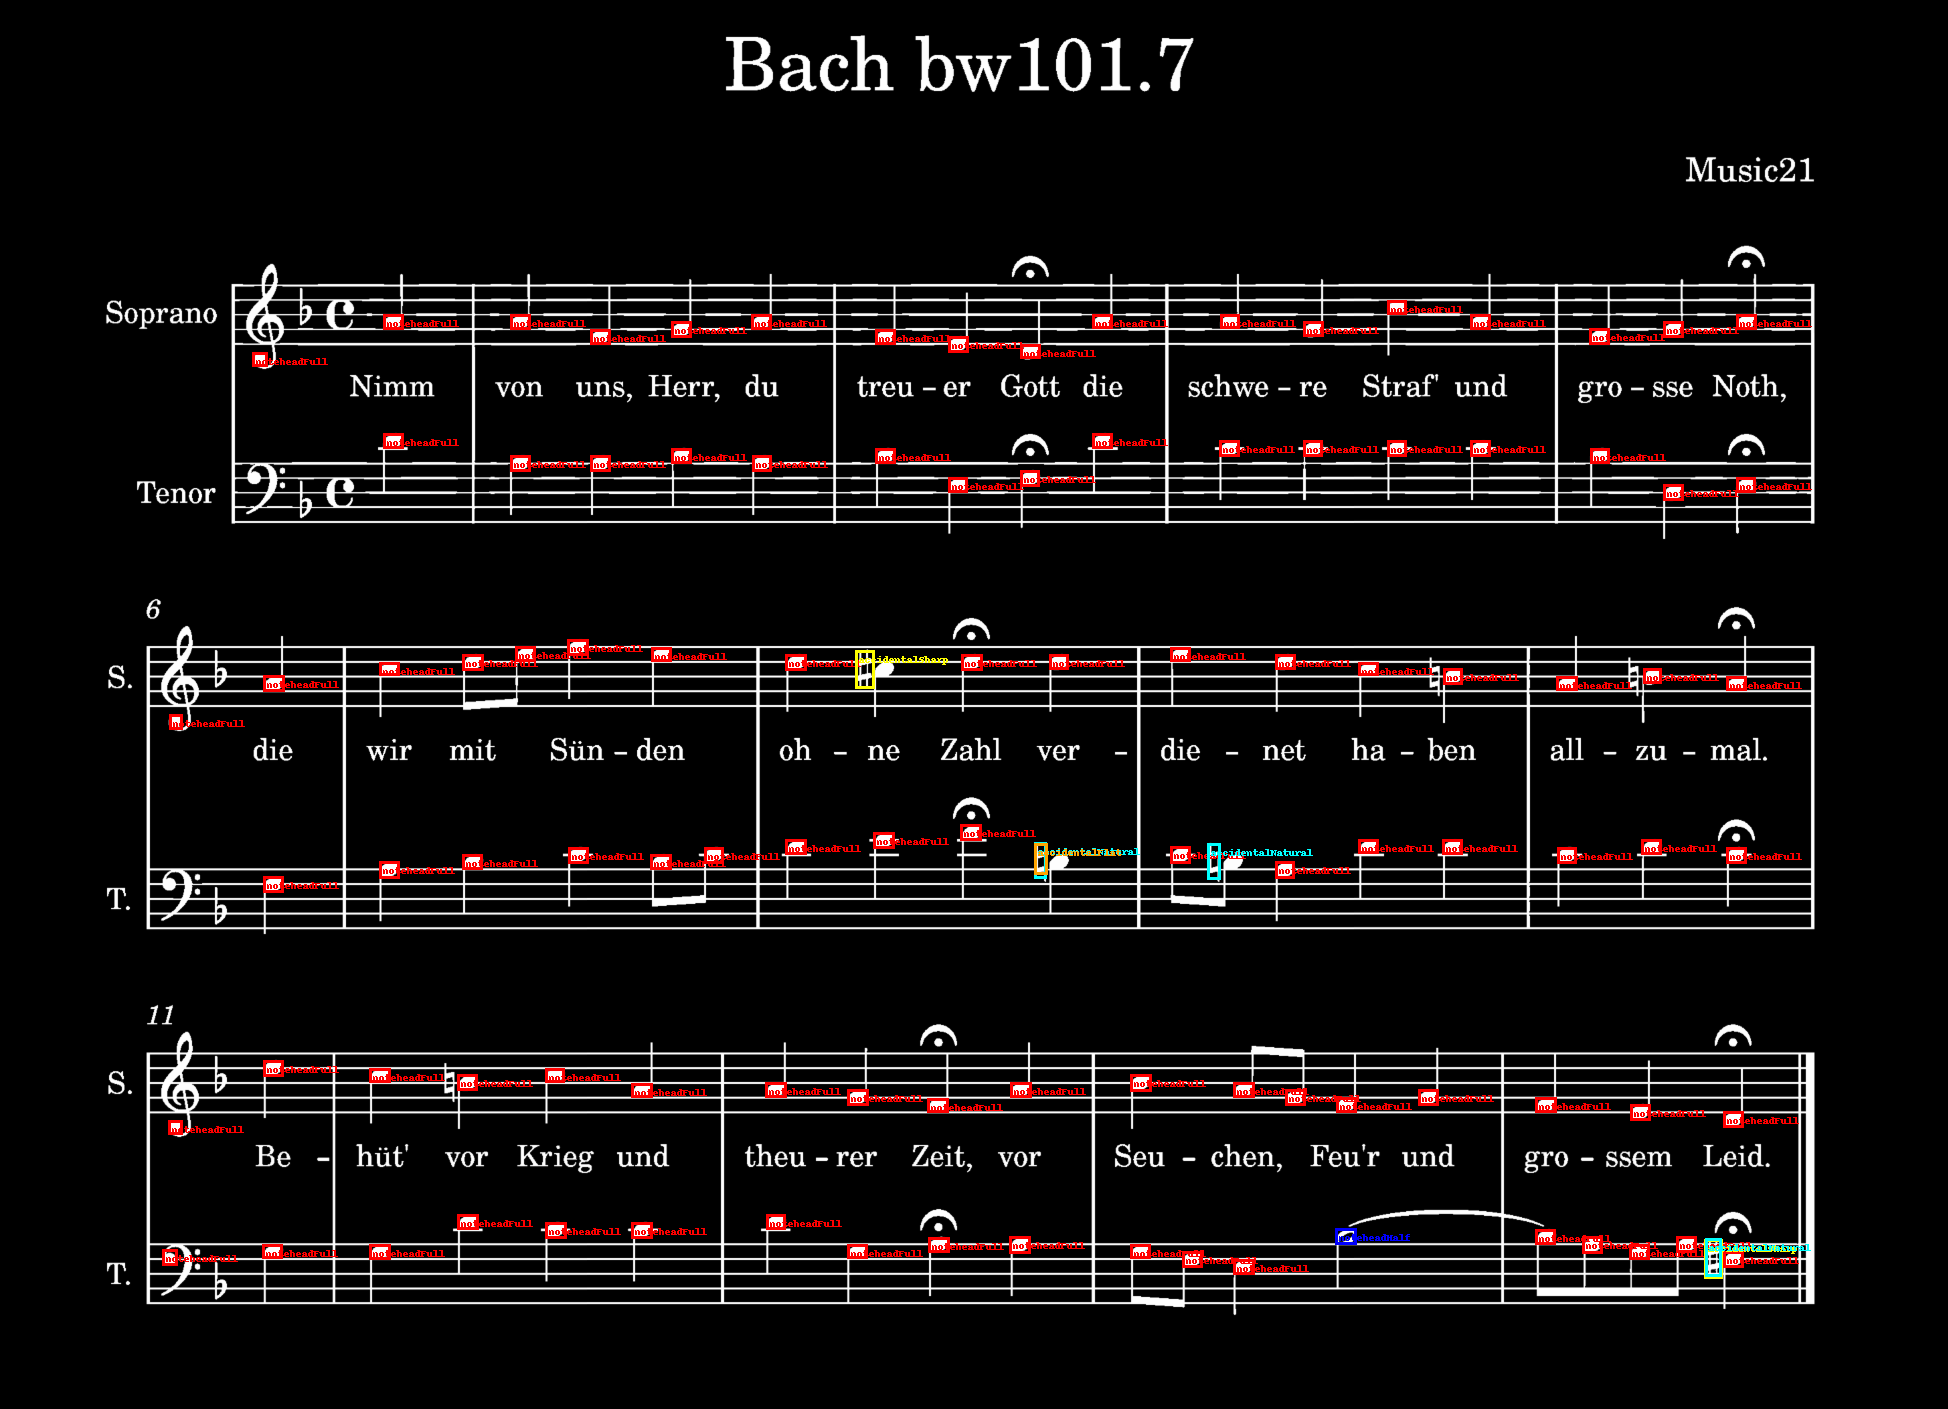

In [9]:
from omrmodules.datasets.MuscimaObjects import __pitch_objects__
label_dict = __pitch_objects__.copy()
label_dict.insert(0, "__background__")
visualize_bboxes(sample_image, object_dict, label_dict, threshold=0.1)


In [94]:
from omrmodules.semantics import SystemObjects
from omrmodules.semantics import SoundObjects
reload(SystemObjects)
reload(SoundObjects)
song = SystemObjects.SongFactory(sample_image, measure_dict, object_dict).song


In [95]:
song.toStream().show('musicxml')


In [13]:
from PIL import Image
import torch
from torchvision.utils import draw_bounding_boxes
boxes2 = []
for system in song.systems:
    for measure in system.measures:
        boxes2.append(measure.bbox())


def visualize(image, boxes):
    viz_image = torch.asarray(image)
    viz_image = (viz_image*255).type(torch.ByteTensor)
    viz_boxes = SystemObjects.denormalize_bboxes(np.asarray(boxes), viz_image)
    viz_boxes = torch.asarray(viz_boxes)

    viz_im_with_bounding_boxes = draw_bounding_boxes(
        viz_image, viz_boxes, width=5, colors="red")

    return Image.fromarray(np.moveaxis(viz_im_with_bounding_boxes.numpy(), 0, -1))


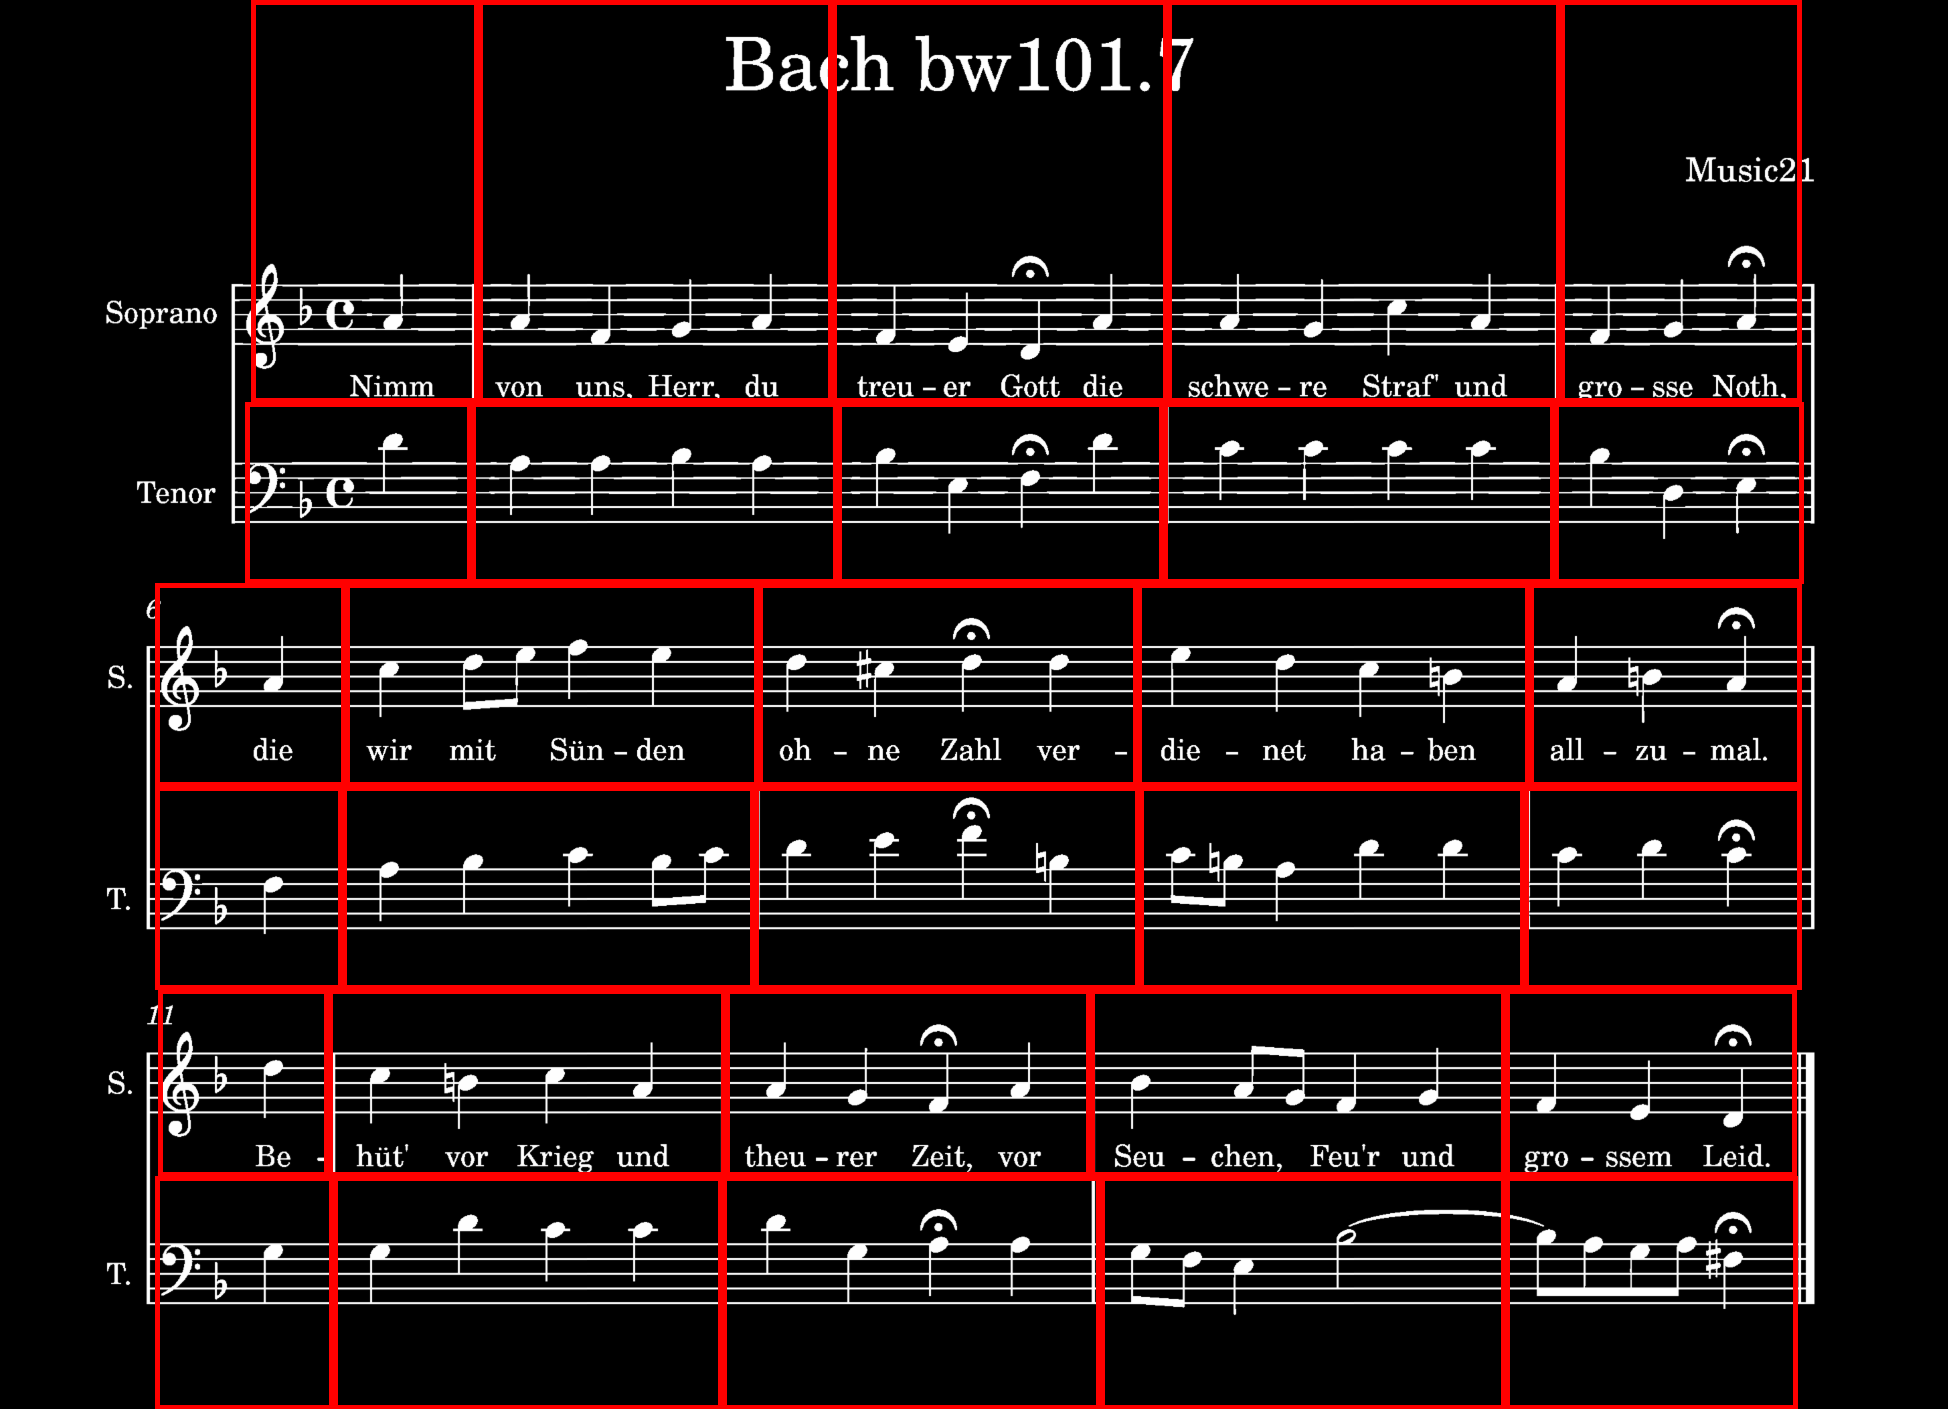

In [14]:
visualize(sample_image, boxes2)


In [92]:
song.one_handed


False

In [16]:
system1 = song.systems[0]
staff1 = system1.staves[0]
m1 = song.systems[0].measures[1]


In [99]:
systems = song.systems

sample_system = systems[0]
sample_staff = systems[0].staves[0]


In [133]:

m21soprano = music21.stream.Part()
m21bass = music21.stream.Part()
kbf = music21.key.KeySignature(-1)
for idx, system in enumerate(systems):
    clef = 'gClef' if idx % 2 == 0 else 'fClef'
    measures = system.measures
    bot = system.staves[0].getbot()
    gap = system.staves[0].getgap()
    m21staff = music21.stream.Stream()
    for measure in measures:
        glyphs = measure.objects
        relposes = [note.relativePos(bot, gap) for note in glyphs if note.__class__ is SoundObjects.Note]
        noteSeq = [SoundObjects.getNote(clef, pos) for pos in relposes]
        noteSeq = normalizeDurations(noteSeq)
        m21measure = music21.stream.Measure(noteSeq)
        # apply key signature
        for j in m21measure.recurse().notes:
            nStep = j.pitch.step
            rightAccidental = kbf.accidentalByStep(nStep)
            j.pitch.accidental = rightAccidental
        acc_idx = [idx for idx, glyph in enumerate(
            glyphs) if glyph.__class__ is SoundObjects.Accidental]
        # apply accidentals
        for acc in acc_idx:
            if acc < len(m21measure.notes):
                if glyphs[acc].type == 'accidentalSharp':
                    m21measure.notes[acc].pitch.accidental = music21.pitch.Accidental(1)
                elif glyphs[acc].type == 'accidentalFlat':
                    m21measure.notes[acc].pitch.accidental = music21.pitch.Accidental(-1)
                elif glyphs[acc].type == 'accidentalNatural':
                    m21measure.notes[acc].pitch.accidental = music21.pitch.Accidental(0)
        m21staff.append(m21measure)
    if idx % 2 == 0:
        m21soprano.append(m21staff)
    else:
        m21bass.append(m21staff)
m21soprano.keySignature = kbf
m21bass.keySignature = kbf
m21score = music21.stream.Stream([m21soprano, m21bass])



In [56]:

noteSeq[0].duration = music21.duration.Duration(2.0)
m21measure = music21.stream.Measure(noteSeq)
m21measure.show('musicxml')


In [108]:
noteSeq[0].pitch.accidental = music21.pitch.Accidental(-1)

In [81]:
m21measure.recurse().notes


<music21.stream.iterator.RecursiveIterator for Measure:0x1df4e1408b0 @:0>

In [90]:
def normalizeDurations(notelist):
    n = len(notelist)
    if n == 4:
        pass
    elif n < 4:
        notelist[n-1].duration = music21.duration.Duration(5.0-n)
    elif 9 > n > 4:
        for i in range((n-4)*2):
            notelist[-i-1].duration = music21.duration.Duration(0.5)
    return notelist


In [134]:
m21score.show('musicxml')


In [124]:
for idx, system in enumerate(systems):
    print(idx)
    print(system)


0
1
2
3
4
5
